In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [ ]:

!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 33.9 MB/s 
     |████████████████████████████████| 182 kB 73.7 MB/s 
     |████████████████████████████████| 7.6 MB 53.4 MB/s 


## Loading data



In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data/Final_dataset.csv')

In [ ]:
data


,Unnamed: 0,Post,Suicidal_label,Sentiment_label
0,0,Ex Wife Threatening SuicideRecently I left my ...,0,0
1,1,Am I weird I don t get affected by compliments...,1,1
2,2,Finally is almost over So I can never hear ...,1,0
3,3,i need helpjust help me im crying so hard,0,0
4,4,I m so lostHello my name is Adam and I ve b...,0,0
...,...,...,...,...
226948,227680,I sound like a dudebro but I can t handle my f...,0,0
226949,227681,Fuck my sister She is such I fucking bitch and...,1,0
226950,227682,I ve been suicidal for years and no one knowsT...,0,1
226951,227683,My boyfriend is sick so I took some Polaroids ...,1,0


In [ ]:
data = data.dropna()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data.index.values, 
                                                  data.Sentiment_label.values, 
                                                  test_size=0.15, 
                                                  random_state=17, 
                                                  stratify=data.Sentiment_label.values)

In [ ]:
data['data_type'] = ['not_set']*data.shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
label_dict = {'Negative': 0, 'Positive': 1, 'Neutral': 2}

##Loading Tokenizer and Encoding our Data:

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    data[data.data_type=='train'].Post.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    data[data.data_type=='val'].Post.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)



input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
label_train = torch.tensor(data[data.data_type=='train'].Sentiment_label.values)


input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
label_val = torch.tensor(data[data.data_type=='val'].Sentiment_label.values)



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train,label_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val,label_val)

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Creating Data Loaders

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup


In [ ]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
epochs = 1

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## Defining our Performance Metrics

In [ ]:
from sklearn.metrics import f1_score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Creating our Training Loop

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
def evaluate(dataloader_val):

    model.eval()
    losses=[]
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        losses.append(loss.item())
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return losses,loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        # print(batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/content/drive/MyDrive/Data/Sentiment_model_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)             
    tqdm.write(f'Training loss: {loss_train_avg}')

In [ ]:
losses, val_loss, predictions, true_vals = evaluate(dataloader_validation)
val_f1 = f1_score_func(predictions, true_vals)
tqdm.write(f'Validation loss: {val_loss}')
tqdm.write(f'F1 Score (Weighted): {val_f1}')

Validation loss: 0.27319068228544846
F1 Score (Weighted): 0.8849458084890568


In [ ]:
accuracy_per_class(predictions, true_vals)

Class: Negative
Accuracy: 20734/21686

Class: Positive
Accuracy: 3374/4145

Class: Neutral
Accuracy: 4105/5972



In [ ]:
preds = np.argmax(predictions, axis=1).flatten()

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_vals,preds)

In [ ]:
cm

array([[20734,   232,   720],
       [  303,  3374,   468],
       [ 1276,   591,  4105]])

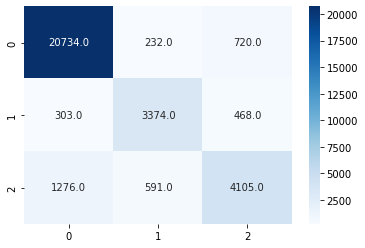

In [ ]:
sns.heatmap(cm.astype(int),annot=True, cmap='Blues',fmt=".1f")

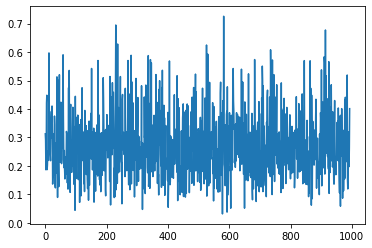

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)

## Loading testset and evaluating the performance of model on this data

In [ ]:
testset = pd.read_csv('/content/drive/MyDrive/Data/testset.csv')
testset.head()


,Unnamed: 0,Post,Suicidal_label,Sentiment_label
0,0,I ve pushed everyone awayI moved away from my ...,0,0
1,1,Gonna go cook some ramen boys And I don t mean...,1,2
2,2,smilemy father today smiled at me but it looke...,0,0
3,3,I keep being told to be careful by people th...,0,0
4,4,Yoo anyone down to give me some advice or just...,1,0


Tokenizing data

In [ ]:
encoded_data_test = tokenizer.batch_encode_plus(
    testset.Post.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)



input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
label_test = torch.tensor(testset.Sentiment_label.values)





/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
dataset_test = TensorDataset(input_ids_test, attention_masks_test,label_test)


## Creating Data Loaders



In [ ]:
batch_size = 32

dataloader_test = DataLoader(dataset_test, 
                              sampler=RandomSampler(dataset_test), 
                              batch_size=batch_size)

## Evaluate

In [ ]:
losses_test, test_loss, predictions, true_vals = evaluate(dataloader_test)


In [ ]:
accuracy_per_class(predictions, true_vals)

Class: Negative
Accuracy: 4209/4352

Class: Positive
Accuracy: 647/770

Class: Neutral
Accuracy: 895/1250



In [ ]:
test_f1 = f1_score_func(predictions, true_vals)
print("F1 Score for test dataset is:", test_f1)

F1 Score for test dataset is: 0.9003423581658921


In [ ]:
preds = np.argmax(predictions, axis=1).flatten()

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_vals,preds)

In [ ]:
cm

array([[4209,   33,  110],
       [  40,  647,   83],
       [ 248,  107,  895]])

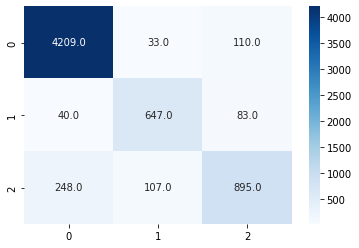

In [ ]:
sns.heatmap(cm.astype(int),annot=True, cmap='Blues',fmt=".1f")

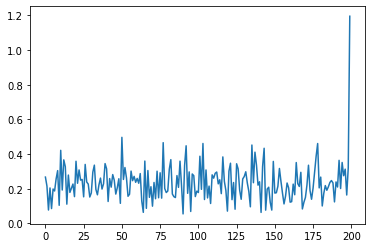

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses_test)